**Using Machine Learning to Predict Football Game Outcomes**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
# # Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_folder = '/content/drive/My Drive'

Mounted at /content/drive


In [8]:
# downloaded from https://www.football-data.co.uk/englandm.php

FG_data = pd.read_csv('/content/drive/My Drive/AIBiz/FB_2023_AI.csv')

**Data Processing**

In this section, We will show you the process I undertook to shortlist the most relevant factors that will significantly impact the accuracy of the model I create.

In [9]:
FG_data.shape

(380, 108)

The dataset obtained consists of 380 rows and 108 columns.

In [10]:
FG_data.isnull().sum()

Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
           ..
PCAHA       0
MaxCAHH     0
MaxCAHA     0
AvgCAHH     0
AvgCAHA     0
Length: 108, dtype: int64

none of the data points are missing

In [11]:
FG_data.info

<bound method DataFrame.info of     Div        Date   Time        HomeTeam       AwayTeam  \
0    E0    5/8/2022  20:00  Crystal Palace        Arsenal   
1    E0    6/8/2022  12:30          Fulham      Liverpool   
2    E0    6/8/2022  15:00     Bournemouth    Aston Villa   
3    E0    6/8/2022  15:00           Leeds         Wolves   
4    E0    6/8/2022  15:00       Newcastle  Nott'm Forest   
..   ..         ...    ...             ...            ...   
375  E0  28/05/2023  16:30         Everton    Bournemouth   
376  E0  28/05/2023  16:30           Leeds      Tottenham   
377  E0  28/05/2023  16:30       Leicester       West Ham   
378  E0  28/05/2023  16:30      Man United         Fulham   
379  E0  28/05/2023  16:30     Southampton      Liverpool   

     H_Ranking_Prior_Season  A_Ranking_Prior_Season  FTHG  FTAG FTR  ...  \
0                        12                       5     0     2   A  ...   
1                        18                       2     2     2   D  ...   
2      

In [12]:
FG_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,H_Ranking_Prior_Season,A_Ranking_Prior_Season,FTHG,FTAG,FTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,5/8/2022,20:00,Crystal Palace,Arsenal,12,5,0,2,A,...,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85
1,E0,6/8/2022,12:30,Fulham,Liverpool,18,2,2,2,D,...,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99
2,E0,6/8/2022,15:00,Bournemouth,Aston Villa,18,14,2,0,H,...,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00
3,E0,6/8/2022,15:00,Leeds,Wolves,17,10,2,1,H,...,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81
4,E0,6/8/2022,15:00,Newcastle,Nott'm Forest,11,18,2,0,H,...,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86


In [13]:
FG_data.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'H_Ranking_Prior_Season',
       'A_Ranking_Prior_Season', 'FTHG', 'FTAG', 'FTR',
       ...
       'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH',
       'MaxCAHA', 'AvgCAHH', 'AvgCAHA'],
      dtype='object', length=108)

**EDA (Exploratory Data Analysis)**

As a part of exploratory data analysis or EDA, the first trend we analysed was the
percentage of games won by the Home team, Away Team and Draws

In [14]:
# Keep only columns that can inform matches before game or during half time
FG_data = FG_data[['Date','Time','HomeTeam','AwayTeam','HS','AS','H_Ranking_Prior_Season','A_Ranking_Prior_Season','FTHG','FTAG','FTR','HTHG','HTAG','HTR','Referee','B365H','B365D','B365A']]


In [15]:
FG_data.head()

,Date,Time,HomeTeam,AwayTeam,HS,AS,H_Ranking_Prior_Season,A_Ranking_Prior_Season,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,B365H,B365D,B365A
0,5/8/2022,20:00,Crystal Palace,Arsenal,10,10,12,5,0,2,A,0,1,A,A Taylor,4.20,3.6,1.85
1,6/8/2022,12:30,Fulham,Liverpool,9,11,18,2,2,2,D,1,0,H,A Madley,11.00,6.0,1.25
2,6/8/2022,15:00,Bournemouth,Aston Villa,7,15,18,14,2,0,H,1,0,H,P Bankes,3.75,3.5,2.00
3,6/8/2022,15:00,Leeds,Wolves,12,15,17,10,2,1,H,1,1,D,R Jones,2.25,3.4,3.20
4,6/8/2022,15:00,Newcastle,Nott'm Forest,23,5,11,18,2,0,H,0,0,D,S Hooper,1.66,3.8,5.25


Date = Match Date (dd/mm/yy)

Time = Time of match kick off

H_Ranking_Prior_Season = Home team ranking in Last season

A_Ranking_Prior_Season = Away team ranking in Last season

FTHG and HG = Full Time Home Team Goals

FTAG and AG = Full Time Away Team Goals

HS= HOME TEAM SHOTS(Additional data added)

AS= AWAY TEAM SHOTS(Additional data added)

FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)

HTHG = Half Time Home Team Goals

HTAG = Half Time Away Team Goals

HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

B365H = Bet365 home win odds

B365D = Bet365 draw odds

B365A = Bet365 away win odds

In [16]:
# Shape of data
print('Shape of data: ', FG_data.shape)
print('\n')
# Is there a home team advantage?
print('Full time results:')
print(FG_data['FTR'].value_counts() / FG_data.shape[0])

print('\n')
# Is there a home team advantage at half time?
print('Half time results:')
print(FG_data['HTR'].value_counts() / FG_data.shape[0])


Shape of data:  (380, 18)


Full time results:
H    0.484211
A    0.286842
D    0.228947
Name: FTR, dtype: float64


Half time results:
D    0.384211
H    0.363158
A    0.252632
Name: HTR, dtype: float64


The purpose of finding out the percentage of games won by the home or away side was to determine whether home advantage — a phenomenon in most sports wherein the team whose ground the game is being played at often gets additional benefit due to fan support — did have a significant impact and whether it should be included as a critical feature while creating a model, and evidently as seen above it has a significant impact on the outcome of the game with the home team winning approximately 48% of the time.

**Correlation Matrix for Predictor Variables**

For the following data exploration stage, We tried to see how well the temporary result at the half-time of a particular game could be used to determine the full-time result.

**To see a correlation between the two, I created a fundamental confusion matrix**

As visible, the game’s result at halftime was reasonably predictive of the full-time result except in the case of a draw, in which case the results are evenly spread out between the 3 possible outcomes.

In [17]:
#confusion matrix of team results based on half-time
print('Confusion matrix, half-time to full-time')
print(pd.crosstab(FG_data['HTR'], FG_data['FTR'], rownames=['Half-Time'], colnames=['Full-Time']))

Confusion matrix, half-time to full-time
Full-Time   A   D    H
Half-Time             
A          62  22   12
D          39  51   56
H           8  14  116


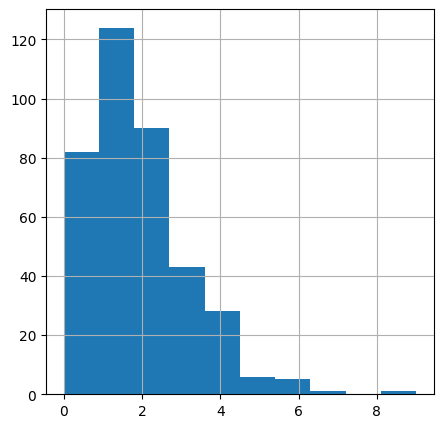

In [18]:
# Histogram of full-time home team goals
FG_data['FTHG'].hist(bins=10, figsize=(5,5))
plt.show()

**Correlation between the final outcome of a game and the goal difference between the two teams at halftime**

<ipython-input-19-bc35489a69e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FG_data['half_time_GD'] = FG_data['HTHG'] - FG_data['HTAG']


<Axes: >

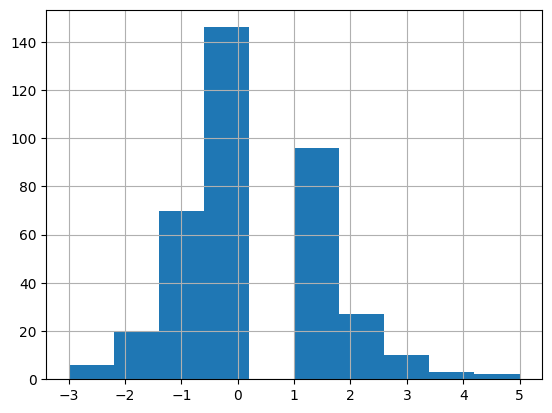

In [19]:
## Variable creation (point difference at half: Home Goals - Away Goals)
FG_data['half_time_GD'] = FG_data['HTHG'] - FG_data['HTAG']

## Explore how predictive the goal difference is of final outcomes
FG_data['half_time_GD'].hist()


In [20]:
print('Confusion matrix, half-time goal difference compared to full-time match result')
print(pd.crosstab(FG_data['half_time_GD'], FG_data['FTR'], rownames=['Half-Time Goal Difference (Home - Away)'], colnames=['Full-Time']))


Confusion matrix, half-time goal difference compared to full-time match result
Full-Time                                 A   D   H
Half-Time Goal Difference (Home - Away)            
-3                                        6   0   0
-2                                       17   1   2
-1                                       39  21  10
 0                                       39  51  56
 1                                        7  14  75
 2                                        1   0  26
 3                                        0   0  10
 4                                        0   0   3
 5                                        0   0   2


<ipython-input-21-ddf12ed9c012>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FG_data['full_time_GD'] = FG_data['FTHG'] - FG_data['FTAG']


<Axes: >

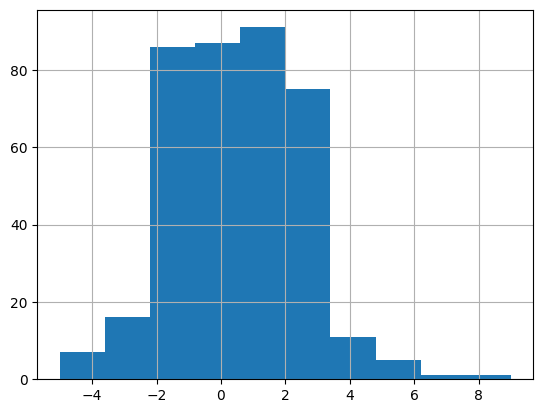

In [21]:
## Variable creation (point difference at full time: Home Goals - Away Goals)
FG_data['full_time_GD'] = FG_data['FTHG'] - FG_data['FTAG']

## Explore how predictive the goal difference is of final outcomes
FG_data['full_time_GD'].hist()

I was able to identify that the number of goals at Half-time or the goal difference between the two gave a fairly decent indication of which team had the greater chance of winning and thus, I decided to include those two columns as my shortlist.

**Plotting scatter plots for the betting odds**

Text(0, 0.5, 'Home team goals (full time)')

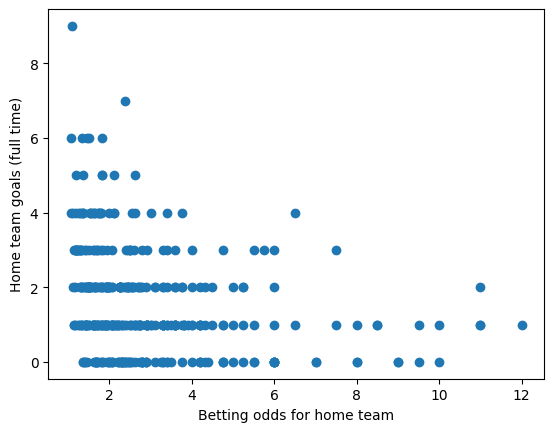

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x = FG_data['B365H'], y = FG_data['FTHG'])
ax.set_xlabel('Betting odds for home team')
ax.set_ylabel('Home team goals (full time)')

Text(0, 0.5, 'Full time goal difference (home - away)')

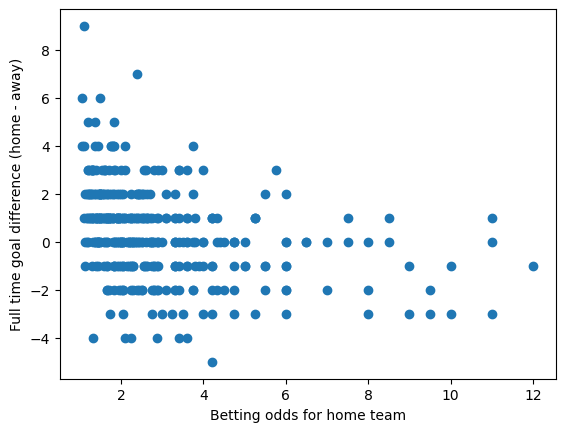

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x = FG_data['B365H'], y = FG_data['full_time_GD'])
ax.set_xlabel('Betting odds for home team')
ax.set_ylabel('Full time goal difference (home - away)')

They did have some kind of a trend

**Plotting scatter plots for the Ranking of the teams**

Text(0, 0.5, 'Full time goal difference (home - away)')

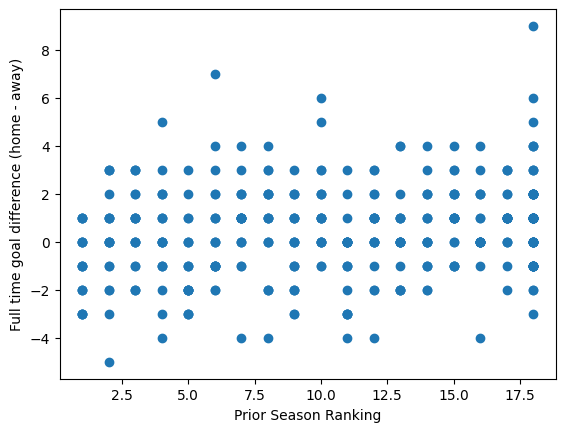

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x = FG_data['A_Ranking_Prior_Season'], y = FG_data['full_time_GD'])
ax.set_xlabel('Prior Season Ranking')
ax.set_ylabel('Full time goal difference (home - away)')

Since we do not know which model would work best with the dataset, we will have to compare the accuracies yielded by each model.
Each model that will be created will also be compared with the results of the baseline model.

The 3 different models that I have decided to design for this dataset are:

1.   Linear Regression Model
2.   Decision Trees Model
3.   Random Forest Model







**Convert the categorical data into Dummies**

One-hot encoding essentially refers to a technique often used to represent categorical variables — variables that can take on a limited number of distinct such as colours (red, green, blue) — as numerical values in any particular machine learning model.

**Separating the independent variables (X) and the dependent variable (y)**

In [25]:
# separate features from the target
y = FG_data['FTR'] # target variable (winning team)
X = FG_data.drop(columns = ['Date','Time','Referee','FTR','FTHG','FTAG','full_time_GD'])
X.shape
X.info

<bound method DataFrame.info of            HomeTeam       AwayTeam  HS  AS  H_Ranking_Prior_Season  \
0    Crystal Palace        Arsenal  10  10                      12   
1            Fulham      Liverpool   9  11                      18   
2       Bournemouth    Aston Villa   7  15                      18   
3             Leeds         Wolves  12  15                      17   
4         Newcastle  Nott'm Forest  23   5                      11   
..              ...            ...  ..  ..                     ...   
375         Everton    Bournemouth  13   7                      16   
376           Leeds      Tottenham  19  11                      17   
377       Leicester       West Ham  13  16                       8   
378      Man United         Fulham  21  10                       6   
379     Southampton      Liverpool  15  30                      15   

     A_Ranking_Prior_Season  HTHG  HTAG HTR  B365H  B365D  B365A  half_time_GD  
0                         5     0     1   A   

In [26]:
#One-Hot encode all categorical variables

# Function for one-hot encoding, takes dataframe and features to encode
# returns one-hot encoded dataframe
# from: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
# features to one-hot encode in our data
features_to_encode = ['HomeTeam','AwayTeam']

for feature in features_to_encode:
    X = encode_and_bind(X, feature)

# results of one-hot encoding
X.head()
X.shape

(380, 51)


**Splitting the data into 70% train and 30% test set**

In [27]:
#split into test and training datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
## Baseline model
### Using half time results to predict full time (e.g. if half time winning, then predict full time winning)

# make predictions
y_pred_train = X_train['HTR']
y_pred_test = X_test['HTR']

In [29]:
from sklearn.metrics import accuracy_score

print('Accuracy on Train data: ', round(accuracy_score(y_pred_train, y_train), 3))
print('Accuracy on Test data: ', round(accuracy_score(y_pred_test, y_test),3))


Accuracy on Train data:  0.594
Accuracy on Test data:  0.623


The first model I will compare with the baseline model is the Logistic Regression Model

**Logistic Regression**

In [30]:
from sklearn.linear_model import LogisticRegression

features_to_encode = ['HTR']

for feature in features_to_encode:
    X_train = encode_and_bind(X_train, feature)

for feature in features_to_encode:
    X_test = encode_and_bind(X_test, feature)

# results of one-hot encoding
X_train.head()

,HS,AS,H_Ranking_Prior_Season,A_Ranking_Prior_Season,HTHG,HTAG,B365H,B365D,B365A,half_time_GD,...,AwayTeam_Man United,AwayTeam_Newcastle,AwayTeam_Nott'm Forest,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_West Ham,AwayTeam_Wolves,HTR_A,HTR_D,HTR_H
170,18,7,6,18,1,0,1.29,5.50,11.00,1,...,0,0,0,0,0,0,0,0,0,1
308,6,14,13,14,0,0,2.50,3.25,2.88,0,...,0,0,0,0,0,0,0,0,1,0
212,6,17,12,9,0,0,3.80,3.50,2.00,0,...,0,0,0,0,0,0,0,0,1,0
17,13,19,18,7,1,0,4.20,3.60,1.85,1,...,0,0,0,0,0,1,0,0,0,1
234,1,10,8,5,0,0,4.75,4.00,1.70,0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
logit = LogisticRegression()
logit.fit(X_train,y_train)

print('Logistic regression accuracy on train set: ', round(logit.score(X_train,y_train),3))
print('Logistic regression accuracy on test set: ', round(logit.score(X_test,y_test),3))

Logistic regression accuracy on train set:  0.767
Logistic regression accuracy on test set:  0.579


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**We see evidence of overfitting (train accuracy much better than test)**

Overfitting refers to the model almost memorising each data point within the train set as is. Thus, any new data point slightly deviating from the test data will not be accurately predicted.

Thus need to be resolved, which is the exact need for implementing Hyperparameter tuning.

**Hyperparameter Tuning for Logistic Regression**

In the hyperparameter tuning of the logistic regression model, we plot the ‘C’ value against the two Accuracies to find the optimal value of C that yields the best fit for the test data.

The optimal value of ‘C’ gives the best fit and prevents over or under-fitting data. The best fit or maximum accuracy in the diagram below occurs at the C value of 0.00316.

In [32]:
## Adjusting C parameter
logit_tuned = LogisticRegression(penalty = 'l2', C = 0.000001)
logit_tuned.fit(X_train,y_train)

LogisticRegression(C=1e-06)

In [33]:
# storage variables
train_accuracies = []
test_accuracies = []
c_vals = np.logspace(-7, -2.5, num = 100) # Penalty parameters to test

## Hyperparameter tuning for loop
for c_val in c_vals: # For every penalty parameter we're testing

   # Fit model on training data
   logit_tuned = LogisticRegression(penalty = 'l2', C = c_val)
   logit_tuned.fit(X_train, y_train)

   # Store training and test accuracies
   train_accuracies.append(logit_tuned.score(X_train,y_train))
   test_accuracies.append(logit_tuned.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


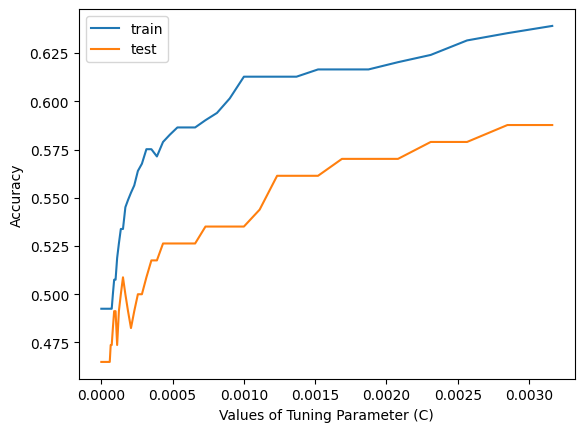

In [34]:
# plot train and test accuracies
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(c_vals, train_accuracies, label = 'train')
ax.plot(c_vals, test_accuracies, label = 'test')
ax.set_xlabel('Values of Tuning Parameter (C)')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')

In [35]:
## Determining maximizing C on test set
print('Maximum test accuracy: ', np.round(test_accuracies[np.argmax(test_accuracies)], 3))
print('Value of C that achieves max test accuracy: ', np.round(c_vals[np.argmax(test_accuracies)],5))


Maximum test accuracy:  0.588
Value of C that achieves max test accuracy:  0.00285


 **K-Nearest Neighbors (KNN)**

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_train = knn_classifier.predict(X_train)
y_pred_test = knn_classifier.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Accuracy on Train data: ', round(accuracy_train, 3))
print('Accuracy on Test data: ', round(accuracy_test, 3))

Accuracy on Train data:  0.688
Accuracy on Test data:  0.509


**Hyperparameter tuning for a K-Nearest Neighbors (KNN)**

Hyperparameter tuning for a K-Nearest Neighbors (KNN) model involves finding the best values for parameters like the number of neighbors (n_neighbors). A common approach is to perform a grid search over a range of hyperparameter values and select the combination that gives the best performance.

The GridSearchCV performs cross-validation to evaluate the model's performance for each combination of hyperparameters and selects the best one.

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': [1,3,5,7,9,11],'weights': ['uniform', 'distance'],'p': [1, 2]}
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', refit='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_
y_pred_test = best_knn_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print('Best Hyperparameters:', best_params)
print('Accuracy on Test data: ', round(accuracy_test, 3))
cv_results = pd.DataFrame(grid_search.cv_results_)
print('Cross-validation results:\n', cv_results[['params', 'mean_test_score']])

Best Hyperparameters: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Accuracy on Test data:  0.632
Cross-validation results:
                                                params  mean_test_score
0    {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}         0.484696
1   {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}         0.484696
2    {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}         0.435570
3   {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}         0.435570
4    {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}         0.529979
5   {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}         0.533473
6    {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}         0.533613
7   {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}         0.507128
8    {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}         0.548707
9   {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}         0.571139
10   {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}         0.503634
11  {'n_neighbors':

**Decision Tree Model**

[Text(0.5, 0.8333333333333334, 'x[9] <= 0.5\ngini = 0.627\nsamples = 266\nvalue = [75, 60, 131]'),
 Text(0.25, 0.5, 'x[6] <= 1.975\ngini = 0.656\nsamples = 169\nvalue = [70, 52, 47]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'x[1] <= 20.0\ngini = 0.241\nsamples = 97\nvalue = [5, 8, 84]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

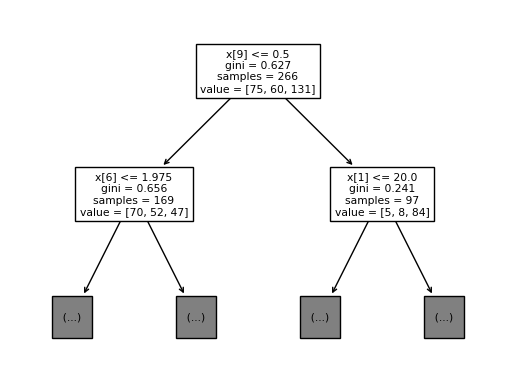

In [38]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

sklearn.tree.plot_tree(tree,max_depth=1)



In [39]:
print('Tree accuracy on train set: ', round(tree.score(X_train,y_train),3))
print('Tree accuracy on test set: ', round(tree.score(X_test,y_test),3))

Tree accuracy on train set:  1.0
Tree accuracy on test set:  0.439


**Hyperparameter tuning of the decision trees:**

We plot the number of minimum samples against the test and train accuracies.


```
# This is formatted as code
```


The minimum samples refer to the number of leaf nodes required in a decision tree and tuning the number of samples allowed in a particular leaf affects the model’s ability to predict the outcome well.

In [40]:
# storage variables
train_accuracies = []
test_accuracies = []
min_vals = np.linspace(0.001, 1, num = 500) # Penalty parameters to test

## Hyperparameter tuning for loop
for min_val in min_vals: # For every penalty parameter we're testing

   # Fit model on training data
   tree_tuned = DecisionTreeClassifier(min_samples_split = min_val)
   tree_tuned.fit(X_train, y_train)

   # Store training and test accuracies
   train_accuracies.append(tree_tuned.score(X_train,y_train))
   test_accuracies.append(tree_tuned.score(X_test,y_test))

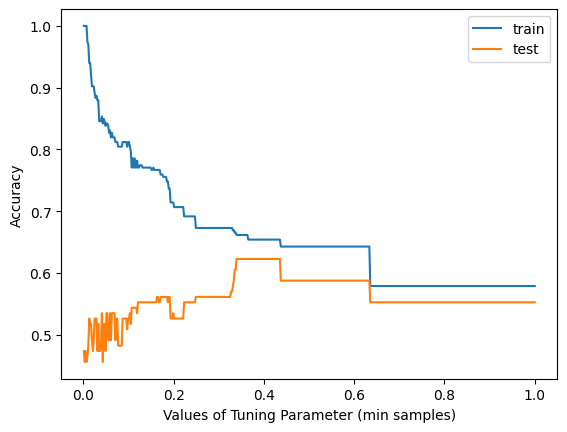

In [41]:
# plot train and test accuracies
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(min_vals, train_accuracies, label = 'train')
ax.plot(min_vals, test_accuracies, label = 'test')
ax.set_xlabel('Values of Tuning Parameter (min samples)')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')

In [42]:
print('Maximum test accuracy: ', np.round(test_accuracies[np.argmax(test_accuracies)], 3))
print('Value of min samples that achieves max test accuracy: ', np.round(min_vals[np.argmax(test_accuracies)],5))


Maximum test accuracy:  0.623
Value of min samples that achieves max test accuracy:  0.33934


**In this case, the minimum number of samples required to give the maximum test accuracy was 0.13513**

**Random Forest Model**

In [43]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)

RandomForestClassifier()

In [44]:
print('Random forest accuracy on train set: ', round(forest.score(X_train,y_train),3))
print('Random Forest accuracy on test set: ', round(forest.score(X_test,y_test),3))

Random forest accuracy on train set:  1.0
Random Forest accuracy on test set:  0.596


**Hyperparameter tuning of the Random Forest:**

we are tuning the minimum number of samples and the minimum number of trees that are required to yield the maximum accuracy

In [45]:
# storage variables
train_accuracies = []
test_accuracies = []
min_vals = np.linspace(0.001, 1, num = 10) # Penalty parameters to test
nTrees = np.arange(1,1000,step=200)

## Hyperparameter tuning for loop
for min_val in min_vals: # For every penalty parameter we're testing
   for nTree in nTrees:
    # Fit model on training data
    forest_tuned = RandomForestClassifier(min_samples_split = min_val, n_estimators = nTree)
    forest_tuned.fit(X_train, y_train)

    # Store training and test accuracies
    train_accuracies.append(forest_tuned.score(X_train,y_train))
    test_accuracies.append(forest_tuned.score(X_test,y_test))

In [46]:
np.argmax(test_accuracies)
print('Maximum test accuracy: ', np.round(test_accuracies[np.argmax(test_accuracies)], 3))
print('Value of min samples that achieves max test accuracy: ', np.round(min_vals[round(np.argmax(test_accuracies)/1000)],5))
print('Value of min trees that achieves max test accuracy: ', np.round(nTrees[1],5))

Maximum test accuracy:  0.64
Value of min samples that achieves max test accuracy:  0.001
Value of min trees that achieves max test accuracy:  201


Before undergoing the process of hyperparameter tuning, the accuracy that was output was **0.623**, and after the process, the final test accuracy is **0.658**.

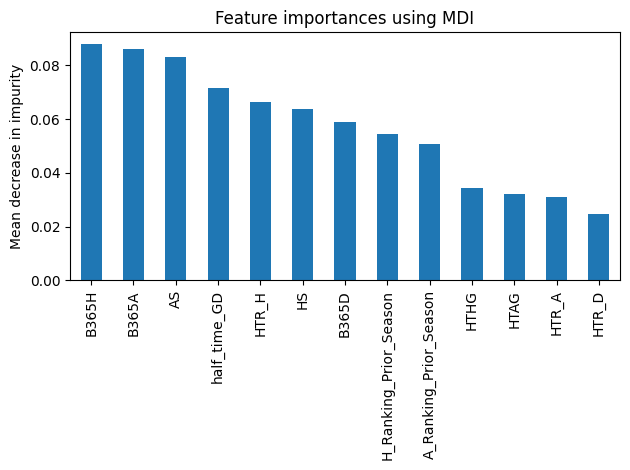

In [47]:
# Get random forest feature importances

importances = forest.feature_importances_
feature_names = X_train.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances[forest_importances > 0.02].sort_values(ascending = False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The phrase **MDI** simply refers to ‘Mean Decrease Impurity’, a measure that is often used to determine the importance of particular features in the prediction process.

** Based on the results, we can successfully conclude that the Random Forests Model gives us the most accurate predictions.**